In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from ark_tweet_nlp import CMUTweetTagger
from tqdm import tqdm_notebook as tqdm
import multiprocessing
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import re
import pickle
import copy

/home/qrg-researchlab/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/qrg-researchlab/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/qrg-researchlab/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/qrg-researchlab/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/qrg-researchlab/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [7]:
"""Loading the data"""
data = pickle.load(open('./label_tag_data.p', 'rb'))

L = []
for k in tqdm(range(data.shape[0])):
    local = data['tag_df'].iloc[k]
    local['word'] = local.word.apply(lambda x: x.lower().replace('-','').replace("'",''))
    L.append(copy.deepcopy(local))
    
data['tag_df'] = pd.Series(L, index=data.index)

"""Loading the split hashtags"""
split_hashtags = pickle.load(open('./hashtags/split_hashtags.p','rb'))

"""Loading the tagged hashtags"""
tagged_hashtags = pickle.load(open('./hashtags/tagged_hashtags_last.p','rb'))

In [8]:
"""Formatting the target to a list"""
y = list(data.pi)

In [9]:
"""Computing PMI for all words"""
lmtzr = WordNetLemmatizer()

words_cond_proba = {}
words_count = {}
class_proba = np.mean(y)

for k in tqdm(range(data.shape[0])):
    local = data.tag_df.iloc[k]
    for i in range(local.shape[0]):
        w = local.word.iloc[i].replace("'",'')
        t = local.tag.iloc[i]
        if local.tag.iloc[i] not in ['U','$','^','&','D','E','M','G','#','.']:
            if t in ['V','A','N']:
                w = lmtzr.lemmatize(w, t.lower())
            try:
                words_cond_proba[w] += y[k]
                words_count[w] += 1
            except KeyError:
                words_cond_proba[w] = y[k]
                words_count[w] = 1
        elif t=='#':
            if w in split_hashtags.keys():
                for v in split_hashtags[w]:
                    try:
                        words_cond_proba[v] += y[k]
                        words_count[v] += 1
                    except KeyError:
                        words_cond_proba[v] = y[k]
                        words_count[v] = 1
        elif '#' in w:
            w = w.replace('#','')
            try:
                words_cond_proba[w] += y[k]
                words_count[w] += 1
            except KeyError:
                words_cond_proba[w] = y[k]
                words_count[w] = 1

## Otsu's thresholding method
It is a clustering method consisting in minimizing the intra-class variable between two classes : $\sigma_w^2(t) = w_0(t).\sigma_0^2(t) + w_1(t).\sigma_1^2(t)$, with $w_0(t)$ being the proportion/probability of class 0 obtained for threshold $t$, and $w_1(t)$ being the proportion/probability of class 1 obtained for threshold $t$.<br/>
I used the PMI between the words which had counts larger than 10 to avoid noisy words, and the thresholds were the scores for each word.<br/>
The problem with this method is that currently, the words do not appear a lot. Which makes the selection method noisy for our data.<br/><br/>

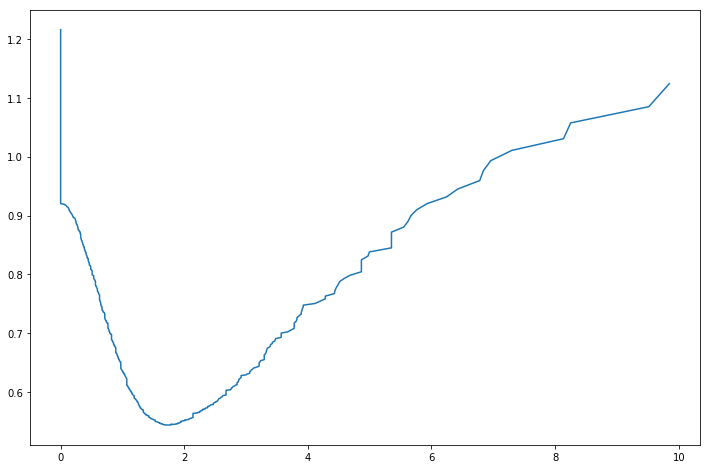

/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


touch                1.742676
word                 1.742676
which                1.742676
apparently           1.754920
rather               1.757539
way                  1.772353
fume                 1.784168
position             1.784168
themselves           1.784168
ill                  1.784168
twice                1.784168
closed               1.784168
w/                   1.784168
act                  1.784168
stewardess           1.784168
behalf               1.784168
respect              1.784168
organisation         1.784168
wheelchair           1.784168
overbooked           1.784168
power                1.784168
pax                  1.784168
gesture              1.784168
earth                1.784168
middle               1.784168
version              1.784168
action               1.784168
@fly_norwegian       1.784168
apart                1.784168
compensate           1.784168
                      ...    
vueling              4.489197
avoid                4.516176
ruin      

In [10]:
"""Computing the PMI for negative PI"""
pmi_series = pd.Series(words_cond_proba)/pd.Series(words_count)/class_proba
count_series = pd.Series(words_count)

"""Otsu's thresholding"""
min_count = 10
pmi_ = pmi_series[count_series>=min_count].sort_values(ascending=True)
intra_var = []
n = pmi_.shape[0]

for k in range(n-1):
    intra_var.append((k+1)/n * np.var(pmi_.iloc[:k]) + (1-(k+1)/n) * np.var(pmi_.iloc[k:]))
    
"""Plotting the intra class variance"""
plt.figure(figsize=(12,8))
plt.plot(pmi_.iloc[:-1], intra_var)
plt.show()

"""Showing some relevant words"""
ind_min = np.argmin(pd.Series(intra_var).fillna(np.inf))
pmi_pos = pmi_.iloc[ind_min:]
pmi_.iloc[ind_min:]

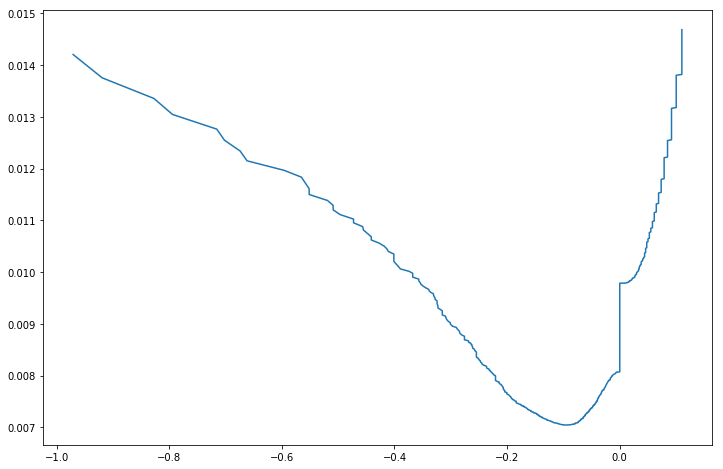

/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


handle         -0.095916
hr             -0.095916
probably       -0.095916
might          -0.095916
world          -0.095916
;              -0.095455
thing          -0.095398
p              -0.095186
worry          -0.095090
leg            -0.095090
job            -0.095090
force          -0.094546
back           -0.094488
find           -0.094339
say            -0.094215
original       -0.093876
lie            -0.093876
claim          -0.093781
sit            -0.093722
few            -0.093654
high           -0.093478
as             -0.093203
offer          -0.093146
??             -0.092830
up             -0.092760
already        -0.092563
ill            -0.091920
earth          -0.091920
organisation   -0.091920
overbooked     -0.091920
                  ...   
reschedule      0.110304
tourist         0.110304
weekly          0.110304
throughout      0.110304
bc              0.110304
director        0.110304
district        0.110304
certificate     0.110304
hmm             0.110304


In [11]:
"""Computing the PMI for non-negative PI class"""
pmi_series = (1. - pd.Series(words_cond_proba))/pd.Series(words_count)/(1-class_proba)
count_series = pd.Series(words_count)

"""Otsu's thresholding"""
min_count = 10
pmi_ = pmi_series[count_series>=10].sort_values(ascending=True)
intra_var = []
n = pmi_.shape[0]

for k in range(n-1):
    intra_var.append((k+1)/n * np.var(pmi_.iloc[:k]) + (1-(k+1)/n) * np.var(pmi_.iloc[k:]))
    
"""Plotting the intra class variance"""
plt.figure(figsize=(12,8))
plt.plot(pmi_.iloc[:-1], intra_var)
plt.show()

"""Showing some relevant words"""
ind_min = np.argmin(pd.Series(intra_var).fillna(np.inf))
pmi_neg = pmi_.iloc[ind_min:]
pmi_.iloc[ind_min:]

## The WordNet similarity
For words in $W_{PA}$, the top words for PMI with positive class, we know the words that predict the positive class are the airlines business consumption words : fly, travel, book, use, avoid, recommend. However, these words have no relationship to each other whatsoever.<br/>
Indeed, experimenting with the first synsets of the words doesn't prove to be useful at all. We find that the first word related to traveling for the synset of 'fly' is 'traveler', with 7 other words being useless from the consumption verbs standing point. Using the WordNet similarity feature doesn't seem to be promising in our case.<br/>
Moreover, for words $w_1$ and $w_2$, further refining needs examininig WN similarity of each and every synset of $w_1$ with each and every synset of $w_2$. Which is not very feasible and too time consuming.

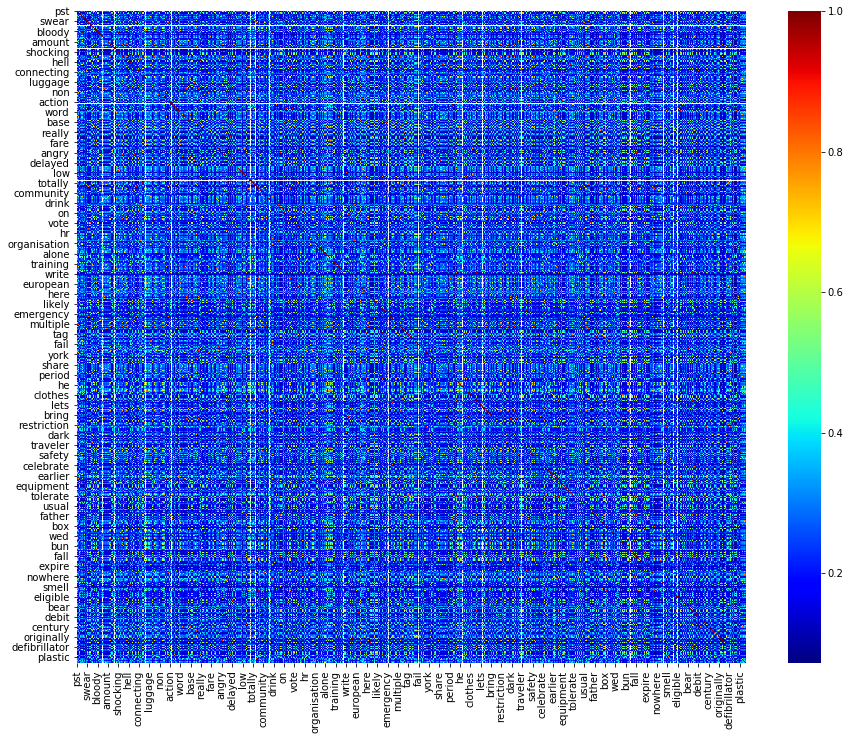

In [12]:
from nltk.corpus import wordnet

synsets = {}

for w in tqdm(pmi_.index):
    try:
        synsets[w] = wordnet.synsets(w)[0]
    except:
        continue
        
words = list(synsets.keys())
syn_sim_df = pd.DataFrame([[synsets[u].wup_similarity(synsets[v]) for v in words] for u in tqdm(words)], index=words, columns=words)

plt.figure(figsize=(15,12))
sns.heatmap(syn_sim_df, cmap='jet')
plt.show()

In [13]:
syn_sim_df['use'].sort_values(ascending=False).iloc[:20]

use              1.000000
activity         0.923077
assistance       0.857143
attempt          0.857143
support          0.857143
game             0.857143
search           0.857143
training         0.857143
job              0.857143
assist           0.857143
help             0.857143
effort           0.857143
procedure        0.857143
process          0.857143
market           0.857143
work             0.857143
protection       0.857143
try              0.857143
practice         0.857143
entertainment    0.800000
Name: use, dtype: float64

In [14]:
syn_sim_df['book'].sort_values(ascending=False).iloc[:20]

book        1.000000
read        0.900000
magazine    0.900000
weekly      0.818182
film        0.777778
movie       0.777778
pic         0.777778
original    0.705882
photo       0.666667
article     0.666667
picture     0.666667
map         0.666667
separate    0.631579
letter      0.631579
still       0.631579
block       0.625000
personal    0.600000
mine        0.588235
load        0.588235
cake        0.588235
Name: book, dtype: float64

In [15]:
syn_sim_df['fly'].sort_values(ascending=False).iloc[:20]

fly           1.000000
queen         0.869565
young         0.700000
entire        0.636364
bird          0.636364
someone       0.631579
somebody      0.631579
individual    0.631579
person        0.631579
engineer      0.600000
suspect       0.600000
national      0.600000
expert        0.600000
user          0.600000
straight      0.600000
white         0.600000
traveller     0.600000
friend        0.600000
longer        0.600000
traveler      0.600000
Name: fly, dtype: float64

## Sentiment analysis
To compute a sentiment for the polarity of the tweets, I use the VADER sentiment analyzer as it is one the most up-to-date sentiment analysis tools that adds valence scores to the words, besides their positivity/negativity.

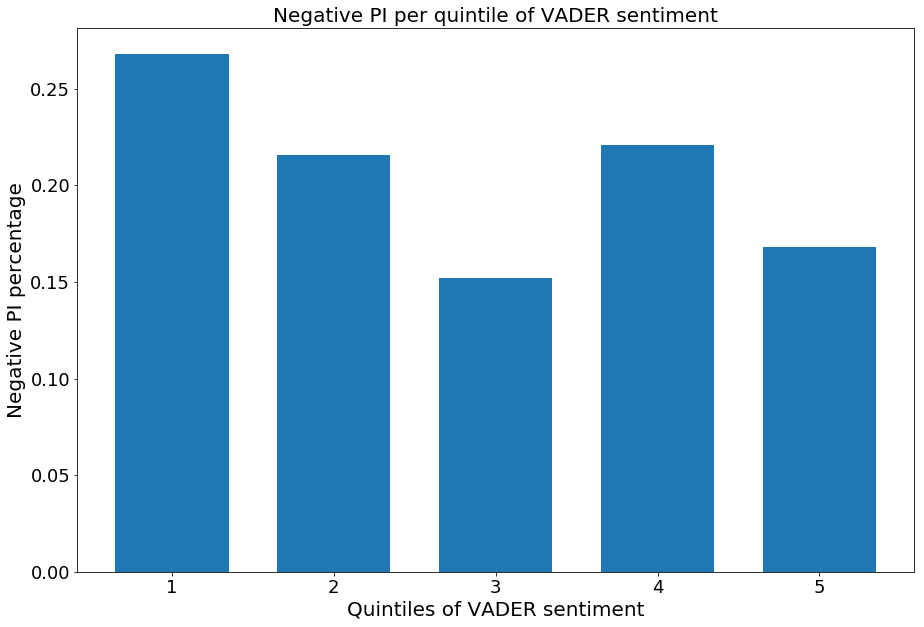

In [17]:
"""Computing sentiment analysis"""
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()
sentiment = [analyser.polarity_scores(sentence)['compound'] for sentence in tqdm(data.text)]

sentiment_data = pd.DataFrame([sentiment, list(data.pi)], index=['sentiment','neg_pi']).T
sentiment_data.sort_values('sentiment', ascending=True, inplace=True)

"""Computing the mean purchase intent per quintile of VADER sentiment"""
pi_by_quintile = [np.mean(sentiment_data.neg_pi.iloc[int(k*n/5):int((k+1)*n/5)]) for k in range(5)]

plt.figure(figsize=(15,10))
plt.bar(x=np.arange(1,6), height=np.array(pi_by_quintile), width=0.7)
plt.xlabel('Quintiles of VADER sentiment', fontsize=20)
plt.ylabel('Negative PI percentage', fontsize=20)
plt.title('Negative PI per quintile of VADER sentiment', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [18]:
"""Correlation between negative PI and sentiment"""
sentiment_data.corr()

,sentiment,neg_pi
sentiment,1.000000,-0.154528
neg_pi,-0.154528,1.000000


## Computing the delta tf-idf weights 
Next, we compute the delta TF-IDF weights as stated in the paper.<br/>
First, we pick the top 10% words in the PMI rankings for both the positive and the negative class.<br/>
Then, we compute for each one of them the score : $d_{tfidf}(w) = log(\frac{N_{w,0}}{N_{w,1}})$.<br/>

In [21]:
pos_word = dict(pmi_pos.iloc[-int(0.2*pmi_pos.shape[0]):])
pos_word = {e: pos_word[e] for e in pos_word.keys() if len(e)>1}

neg_word = dict(pmi_.iloc[:int(0.2*pmi_neg.shape[0])])
neg_word = {e: neg_word[e] for e in neg_word.keys() if len(e)>1}

pw = list(pos_word.keys())
nw = list(neg_word.keys())

pos_count = {w: 0 for w in pw+nw}
neg_count = {w: 0 for w in pw+nw}
notice = set(pw+nw)

for k in tqdm(range(data.shape[0])):
    local = data.tag_df.iloc[k]
    
    for i in range(local.shape[0]):
        t = local.tag.iloc[i]
        w = local.word.iloc[i].replace("'",'')
        
        if local.tag.iloc[i] not in ['U','$','^','&','D','E','M','G','#','.']:
            if t in ['V','A','N']:
                w = lmtzr.lemmatize(w, t.lower())
            try:
                pos_count[w] += y[k]
                neg_count[w] += 1 - y[k]
            except:
                pass
            
        elif t=='#':
            if w in split_hashtags.keys():
                for v in split_hashtags[w]:
                    try:
                        pos_count[v] += y[k]
                        neg_count[v] += 1 - y[k]
                    except:
                        pass
                    
        elif '#' in w:
            w = w.replace('#','')
            try:
                pos_count[w] += y[k]
                neg_count[w] += 1 - y[k]
            except:
                pass
            
delta_tfidf = np.log((1+pd.Series(neg_count))/(1+pd.Series(pos_count))) 

In [22]:
"""Computing bigrams and trigrams for every tweet"""

def find_ngrams(input_list, n):
    try:
        return ['_'.join(input_list[k:k+n]) for k in range(len(input_list)-n)]
    except:
        return []

bigrams = {}
bigrams_class = {}
bigrams_no_class = {}
bigrams_count = {}
trigrams = {}
trigrams_class = {}
trigrams_no_class = {}
trigrams_count = {}

for k in tqdm(range(data.shape[0])):
    local = data.tag_df.iloc[k]
    local_list = []
    for i in range(local.shape[0]):
        t = local.tag.iloc[i]
        w = local.word.iloc[i].replace("'",'').replace('-','').replace('@','')
        if local.tag.iloc[i] not in ['U','$','^','&','D','E','M','G','#',',']:
            if t in ['V','A','N']:
                w = lmtzr.lemmatize(w, t.lower())
            local_list.append(w)
        elif t=='#':
            if w in split_hashtags.keys():
                for v in split_hashtags[w]:
                    local_list.append(v)
        elif '#' in w:
            w = w.replace('#','')
            local_list.append(w)

    local_bigrams = list(find_ngrams(local_list, 2))
    local_trigrams = list(find_ngrams(local_list, 3))
    
    for b in local_bigrams:
        try:
            bigrams[b] += 1
            bigrams_class[b] += y[k]
            bigrams_no_class[b] += 1 - y[k]
            bigrams_count[b] += 1
        except:
            bigrams[b] = 1
            bigrams_class[b] = y[k]
            bigrams_no_class[b] = 1 - y[k]
            bigrams_count[b] = 1
            
    for b in local_trigrams:
        try:
            trigrams[b] += 1
            trigrams_class[b] += y[k]
            trigrams_no_class[b] += 1 - y[k]
            trigrams_count[b] += 1
        except:
            trigrams[b] = 1
            trigrams_class[b] = y[k]
            trigrams_no_class[b] = 1 - y[k]
            trigrams_count[b] = 1
            
cp_bigrams = pd.Series(bigrams_class)/pd.Series(bigrams)
cp_trigrams = pd.Series(trigrams_class)/pd.Series(trigrams)

rank_bigrams = cp_bigrams[pd.Series(bigrams)>=10].sort_values(ascending=False)
rank_trigrams = cp_trigrams[pd.Series(trigrams)>=10].sort_values(ascending=False)

delta_tfidf_bi = np.log((1+pd.Series(bigrams_no_class))/(1+pd.Series(bigrams_class))) 
delta_tfidf_tri = np.log((1+pd.Series(trigrams_no_class))/(1+pd.Series(trigrams_class)))

delta_tfidf_bi = delta_tfidf_bi.loc[[ind for ind in delta_tfidf_bi.index if len(ind)>=5]]
delta_tfidf_tri = delta_tfidf_tri.loc[[ind for ind in delta_tfidf_tri.index if len(ind)>=7]]

print(delta_tfidf_bi.shape)
print(delta_tfidf_tri.shape)


(89380,)
(161965,)


In [24]:
"""Filtering the bigrams and trigrams using the number of appearances"""
delta_tfidf_bi_filter = delta_tfidf_bi[pd.Series(bigrams_count).loc[delta_tfidf_bi.index]>=20]
delta_tfidf_tri_filter = delta_tfidf_tri[pd.Series(trigrams_count).loc[delta_tfidf_tri.index]>=10]

list_bigrams = list(delta_tfidf_bi_filter.index)
list_trigrams = list(delta_tfidf_tri_filter.index)

In [25]:
"""Computing the representations of the tweets"""
reps = []

for k in tqdm(range(data.shape[0]), desc='Building representation of the tweets'):
    local = data.tag_df.iloc[k]
    
    """Extracting the list of words along with hashtag decomposition"""
    local_list = []
    for i in range(local.shape[0]):
        t = local.tag.iloc[i]
        w = local.word.iloc[i].replace("'",'')
        if local.tag.iloc[i] not in ['U','$','^','&','D','E','M','G','#',',']:
            if t in ['V','A','N']:
                w = lmtzr.lemmatize(w, t.lower())
            local_list.append(w)
        elif t=='#':
            if w in split_hashtags.keys():
                for v in split_hashtags[w]:
                    local_list.append(v)
        elif '#' in w:
            w = w.replace('#','')
            local_list.append(w)
            
    """Computing words vector"""
    unigram_vector = [int(w in local_list) * delta_tfidf[w] for w in pw+nw]
    
    """Computing bigrams vector"""
    local_bigrams = list(find_ngrams(local_list, 2))
    bigram_vector = [int(bg in local_bigrams) * delta_tfidf_bi_filter[bg] for bg in list_bigrams]
    
    """Computing trigrams vector"""
    local_trigrams = list(find_ngrams(local_list, 3))
    trigram_vector = [int(tg in local_trigrams) * delta_tfidf_tri_filter[tg] for tg in list_trigrams]
    
    """Aggregating everything and adding Vader sentiment"""
    vector = unigram_vector + bigram_vector + trigram_vector + [sentiment[k]]
    reps.append(vector)

In [26]:
"""Balanced split for cross validation"""

"""Retrieving the positive and negative indexes"""
neg_index = [k for k in range(len(y)) if y[k]==0]
pos_index = [k for k in range(len(y)) if y[k]==1]

"""Shuffling both the positive and negative indexes"""
np.random.seed(seed=0)
np.random.shuffle(neg_index)
np.random.shuffle(pos_index)

"""Computing train and test index sets for the chosen number of folds"""
cv = 10

s = len(neg_index)//cv
neg_index_list = [neg_index[k*s:(k+1)*s] for k in range(cv-1)]
neg_index_list.append(neg_index[(cv-1)*s:])
assert(np.sum([len(e) for e in neg_index_list])==len(neg_index)) # Check on negative index completion

s = len(pos_index)//cv
pos_index_list = [pos_index[k*s:(k+1)*s] for k in range(cv-1)]
pos_index_list.append(pos_index[(cv-1)*s:])
assert(np.sum([len(e) for e in pos_index_list])==len(pos_index))# Check on positive index completion

In [27]:
"""Performing cross-validation for logistic regression on Gupta 14's features"""
X = reps

"""Initializing the list of outputs, predictions and probabilities to computed CV-ly"""
Y = []
Y_Pred = []
Y_Proba = []

"""Intializing the list of cross-validated features"""
precision_list = []
recall_list = []
roc_auc_list = []
f1_list = []

"""Storing coefficients and biases for stability evaluation"""
biases = []
weights = []

"""Performing the cross-validation of the model using the features of interest
A caveat to be mentioned is that the feature selection was performed on the whole dataset, which may be a little biased towards choosing the right features.
This effect will be neglected during this test."""
for k in range(cv):
    """Splitting the data into train and test"""
    print('{}-th fold'.format(k+1))
    print('Splitting the data')
    neg_test = [X[i] for i in neg_index_list[k]]
    pos_test = [X[i] for i in pos_index_list[k]]
    neg_train = [X[i] for i in set(neg_index).difference(neg_index_list[k])]
    pos_train = [X[i] for i in set(pos_index).difference(pos_index_list[k])]

    X_train = pos_train + neg_train
    X_test = pos_test + neg_test

    y_train = [1] * len(pos_train) + [0] * len(neg_train)
    y_test = [1] * len(pos_test) + [0] * len(neg_test)

    """Fitting the model"""
    print('Fitting the model')
    model = LogisticRegression(C=1e4)
    model.fit(X_train, y_train)
    
    print('Evaluation and storage of model parameters\n')
    """Outputting the predictions and the probability scores"""
    y_score = model.predict_proba(X_test)[:,1]
    y_pred = model.predict(X_test)

    """Computing the various metrics"""
    f1_list.append(f1_score(y_test, y_pred))
    precision_list.append(precision_score(y_test, y_pred))
    recall_list.append(recall_score(y_test, y_pred))
    roc_auc_list.append(roc_auc_score(y_test, y_score))

    """Adding predictions and scores to computed global cross-validated performance after the end of the process"""
    Y += list(y_test)
    Y_Pred += list(y_pred)
    Y_Proba += list(y_score)

1-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters

2-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters

3-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters

4-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters

5-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters

6-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters

7-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters

8-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters

9-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters

10-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



In [28]:
"""Performance analysis for our model with 10-fold CV"""
print('Averaged scores')
print('Average {}-fold F1 score : {}'.format(cv, np.mean(f1_list)))
print('Average {}-fold precision : {}'.format(cv, np.mean(precision_list)))
print('Average {}-fold recall : {}'.format(cv, np.mean(recall_list)))
print('Average {}-fold ROC AUC : {}'.format(cv, np.mean(roc_auc_list)))
print('\n')

Averaged scores
Average 10-fold F1 score : 0.47535316978573716
Average 10-fold precision : 0.40706047168260395
Average 10-fold recall : 0.5738886631450629
Average 10-fold ROC AUC : 0.7755318125352376




In [29]:
"""Loading the SVM model"""
precisions = []
recalls = []
aucs = []
fs = []

Cs = np.arange(-4.,4.5,0.5)

"""Looping over the hyperparameter of the error in the SVM cost function"""
for C in Cs:
    
    """Initializing the list of outputs, predictions and probabilities to computed CV-ly"""
    Y = []
    Y_Pred = []
    Y_Proba = []

    """Intializing the list of cross-validated features"""
    precision_list = []
    recall_list = []
    roc_auc_list = []
    f1_list = []

    """Storing coefficients and biases for stability evaluation"""
    biases = []
    weights = []

    """Performing the cross-validation of the model using the features of interest
    A caveat to be mentioned is that the feature selection was performed on the whole dataset, which may be a little biased towards choosing the right features.
    This effect will be neglected during this test."""
    for k in range(cv):
        """Splitting the data into train and test"""
        print('{}-th fold'.format(k+1))
        print('Splitting the data')
        neg_test = [X[i] for i in neg_index_list[k]]
        pos_test = [X[i] for i in pos_index_list[k]]
        neg_train = [X[i] for i in set(neg_index).difference(neg_index_list[k])]
        pos_train = [X[i] for i in set(pos_index).difference(pos_index_list[k])]

        X_train = pos_train + neg_train
        X_test = pos_test + neg_test

        y_train = [1] * len(pos_train) + [0] * len(neg_train)
        y_test = [1] * len(pos_test) + [0] * len(neg_test)

        """Fitting the model"""
        print('Fitting the model')
        model = SVC(C=10**C, probability=True)
        model.fit(X_train, y_train)

        print('Evaluation and storage of model parameters\n')
        """Outputting the predictions and the probability scores"""
        y_score = model.predict_proba(X_test)[:,1]
        y_pred = model.predict(X_test)

        """Computing the various metrics"""
        f1_list.append(f1_score(y_test, y_pred))
        precision_list.append(precision_score(y_test, y_pred))
        recall_list.append(recall_score(y_test, y_pred))
        roc_auc_list.append(roc_auc_score(y_test, y_score))

        """Adding predictions and scores to computed global cross-validated performance after the end of the process"""
        Y += list(y_test)
        Y_Pred += list(y_pred)
        Y_Proba += list(y_score)
        
    fs.append(f1_score(Y, Y_Pred))
    precisions.append(precision_score(Y, Y_Pred))
    recalls.append(recall_score(Y, Y_Pred))
    aucs.append(roc_auc_score(Y, Y_Proba))

1-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


3-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


4-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


5-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


6-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


7-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


8-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


9-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


10-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


3-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


4-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


5-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


6-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


7-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


8-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


9-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


10-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


3-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


4-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


5-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


6-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


7-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


8-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


9-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


10-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


3-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


4-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


5-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


6-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


7-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


8-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


9-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


10-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


3-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


4-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


5-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


6-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


7-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


8-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


9-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


10-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


3-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


4-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


5-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


6-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


7-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


8-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


9-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


10-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


3-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


4-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


5-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


6-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


7-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


8-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


9-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


10-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


3-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


4-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


5-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


6-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


7-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


8-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


9-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


10-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters



/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/qrg-researchlab/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters

2-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters

3-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters

4-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters

5-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters

6-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters

7-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters

8-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters

9-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters

10-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters

1-th fold
Splitting the data
Fitting the model
Evaluation and storage of model parameters

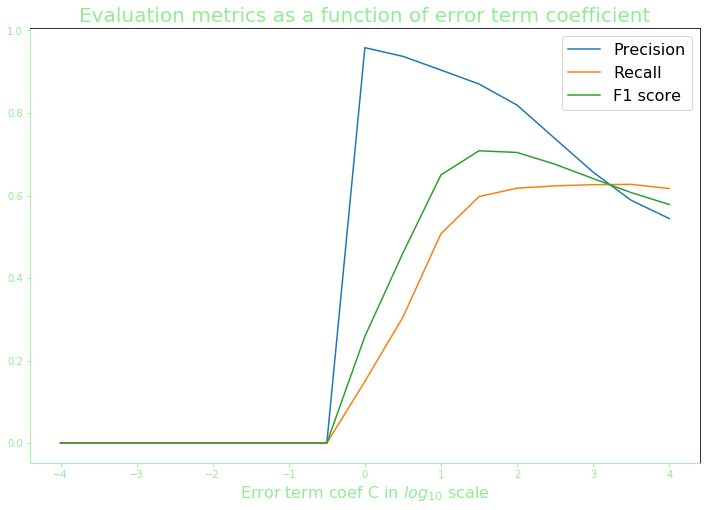

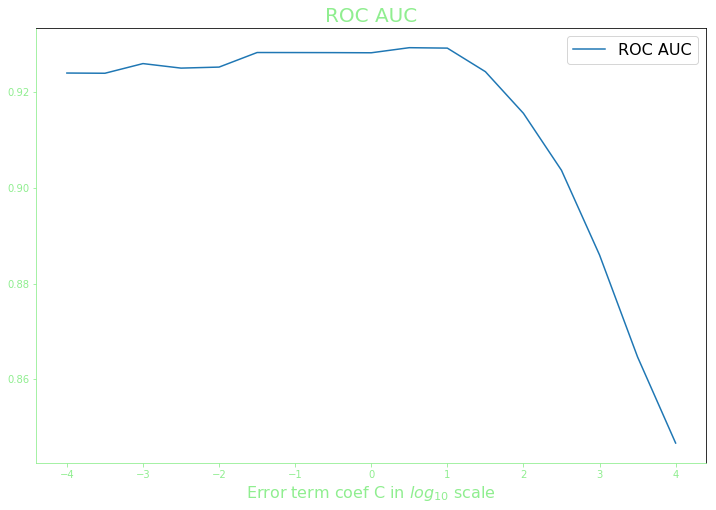

In [33]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

ax.plot(Cs, precisions, label='Precision')
ax.plot(Cs, recalls, label='Recall')
ax.plot(Cs, fs, label='F1 score')
ax.set_xlabel('Error term coef C in $log_{10}$ scale', fontsize=16)

ax.spines['bottom'].set_color('lightgreen')
ax.spines['left'].set_color('lightgreen')
ax.xaxis.label.set_color('lightgreen')
ax.tick_params(axis='x', colors='lightgreen')
ax.tick_params(axis='y', colors='lightgreen')

plt.title('Evaluation metrics as a function of error term coefficient', color='lightgreen', fontsize=20)
plt.legend(fontsize=16)
plt.show()

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

ax.plot(Cs, aucs, label='ROC AUC')
ax.set_xlabel('Error term coef C in $log_{10}$ scale', fontsize=16)

ax.spines['bottom'].set_color('lightgreen')
ax.spines['left'].set_color('lightgreen')
ax.xaxis.label.set_color('lightgreen')
ax.tick_params(axis='x', colors='lightgreen')
ax.tick_params(axis='y', colors='lightgreen')

plt.title('ROC AUC', color='lightgreen', fontsize=20)
plt.legend(fontsize=16)
plt.show()

In [32]:
imax = np.argmax(fs)
print('Best F1 : {}'.format(fs[imax]))
print('Best precision : {}'.format(precisions[imax]))
print('Best recall : {}'.format(recalls[imax]))
print('Best ROC :{}'.format(aucs[imax]))

Best F1 : 0.7084708470847084
Best precision : 0.8702702702702703
Best recall : 0.5974025974025974
Best ROC :0.9242844676147514


In [37]:
data.text.apply(lambda x: ('never' in x.lower() or 'dont' in x.lower()) and 'whenever' not in x.lower()).sum()

3129